In [1]:
## Insert exported WhatsApp chat into data.txt

In [47]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import normalize
from matplotlib.pyplot import cm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import re
from collections import Counter

In [3]:
def load_file(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def filter_messages(messages):
    # Remove all media messages.
    w = [x for x in messages if not "<media omitted>" in x]
    
    # Remove all subject changed messages
    w = [x for x in w if not 'changed the subject from "' in x]
    
    # Remove all group icon changed messages.
    w = [x for x in w if not " changed this group's icon" in x]
    
    # Remove all group description messages the group description
    w = [x for x in w if not "deleted the group description" in x]
    w = [x for x in w if not "changed the group description" in x]
    
    w = [x for x in w if not " added" in x]
    w = [x for x in w if not " left" in x]
    w = [x for x in w if not " removed" in x]

    return w

def map_senders_to_int(senders):
    uniques = np.unique(senders)
    senders_int = []
    for sender in senders:
        senders_int.append(np.where(uniques==sender)[0][0])
    return np.asarray(senders_int)


def create_data_matrix(data):
    lines = data.split('\n')
    lines = list(filter(None, lines))
    lines = filter_messages(lines)
    
    timestamps = []
    senders = []
    messages = []
    
    for index, line in enumerate(lines):
        date = line[12:17] + '/' + line[:10]

        try:
            # try this? 
            # const match = line.match(/([^-]+)\s-\s([^:]+):\s(.+)/);
            # If the timestamp is valid we can assume that sender is found from the line
            # line[19:] contains a string that is of type 'sender: lorem ipsum...'
            # We find ':' and take all characters to its left
            timestamp = datetime.datetime.strptime(date, '%H:%M/%d/%m/%Y')
            sender = line[20:][:line[20:].find(':')].lower()
            
            message = line[19:][line[19:].find(':')+2:].lower()
            
            timestamps.append(timestamp)
            senders.append(sender)
            messages.append(message)
        except ValueError:
            pass
    
    senders_int = map_senders_to_int(senders)
    
    return np.column_stack((np.asarray(timestamps), np.asarray(senders), senders_int, np.asarray(messages)))


def get_top_420(data_matrix):
    blaze_it_am = datetime.datetime.strptime('04:20/01/01/1970', '%H:%M/%d/%m/%Y')
    blaze_it_pm = datetime.datetime.strptime('16:20/01/01/1970', '%H:%M/%d/%m/%Y')
    
    # Indices of messages where time is 04:20 or 16:20
    t_420 = []
    
    for i, t in enumerate(data_matrix.T[0]):
        if t.time() == blaze_it_am.time() or t.time() == blaze_it_pm.time():
            t_420.append(i)
    t_420 = np.asarray(t_420)
    
    # Indices of messages that contain '420'
    m_420 = []
    
    for i, msg in enumerate(data_matrix.T[3]):
        if '420'in msg:
            m_420.append(i)
    
    m_420 = np.asarray(m_420)
    
    # TODO: Filter multiple entries for same day (allow 04:20 and 16:20 separately)
    
    matches = data_matrix[np.intersect1d(t_420,m_420)].T[1]
    values, counts = np.unique(matches,return_counts=True)
    index = np.argmax(counts)
 
    return values[index], counts[index]

def get_list_of_senders(data_matrix):
    return np.unique(data_matrix.T[1]), np.unique(data_matrix.T[2])


def get_longest_rant(data_matrix):
    senders_int = data_matrix.T[2]
    #print(senders_int)
    

def get_activity_by_hour(data_matrix):
    hours = []
    for t in data_matrix.T[0]:
        hours.append(t.hour)

    hours = np.asarray(hours)

    hour, count = np.unique(hours,return_counts=True)
    
    return hour,count

def plot_activity_by_hour(x,y):
    y_pos = np.arange(len(x))
    plt.xticks(y_pos, x)
    plt.plot(x,y)
    plt.ylabel('Messages')
    plt.grid()
    plt.title('Activity by hour')
    plt.show()
    
    
def get_activity_by_day(data_matrix):
    # Monday is 0, Sunday is 6
    weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    days = []
    for t in data_matrix.T[0]:
        days.append(t.weekday())

    days = np.asarray(days)
    
    day, count = np.unique(days, return_counts=True)
    
    return weekdays, count


def plot_activity_by_day(x,y):
    y_pos = np.arange(len(x))
    plt.xticks(y_pos, x)
    plt.bar(y_pos, y, align='center', alpha=0.5)
    plt.ylabel('Messages')
    plt.grid()
    plt.title('Activity by day')
    plt.show()
    

def get_user_activity_by_day(user, data_matrix):
    users, users_int = get_list_of_senders(data_matrix)
    if not user in users:
        raise Exception('User', user, 'not found from user list.')
    messages_by_user = data_matrix[np.where(data_matrix.T[1]==user)]
    weekdays, count = get_activity_by_day(messages_by_user)
    
    return weekdays, count

def get_user_activity_by_hour(user, data_matrix):
    hour_count = {0: 0, 1: 0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0 , 8:0, 9:0, 10:0, 11:0, 12:0, 
                      13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0}
    users, users_int = get_list_of_senders(data_matrix)
    if not user in users:
        raise Exception('User', user, 'not found from user list.')
    messages_by_user = data_matrix[np.where(data_matrix.T[1]==user)]
    dates = messages_by_user.T[0]
    for date in dates:
        h = date.hour
        hour_count[h] = hour_count[h] + 1
        
    hours = np.arange(24)
    count = np.asarray(list(hour_count.values()))
    
    return hours, count

def plot_users_activity_by_day(data_matrix):
    users, users_int = get_list_of_senders(data_matrix)
    
    usr = []
    counts = []
    
    for user in users:
        weekdays, count = get_user_activity_by_day(user, data_matrix)
        if count.shape == np.zeros(7).shape:
            counts.append(np.round(count / np.sum(count), decimals=2))
            usr.append(user)
    counts = np.asarray(counts)
    usr = np.asarray(usr)
    
    matrix = np.column_stack((usr,counts))
    data = matrix.T[1:].astype(np.float)
    
    # Labels
    x_labels = matrix.T[0]
    y_labels = np.asarray(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap=cm.Greens, interpolation='nearest')

    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    for i in range(len(y_labels)):
        for j in range(len(x_labels)):
            text = ax.text(j, i, data[i, j],
                           ha="center", va="center", color="black")

    ax.set_title('Distribution of messages across weekdays')
    fig.tight_layout()
    plt.show()
    
    
def plot_users_activity_by_hour(data_matrix):
    users, users_int = get_list_of_senders(data_matrix)
    
    usr = []
    counts = []
    
    for user in users:
        hours, count = get_user_activity_by_hour(user, data_matrix)
        if count.shape == np.zeros(24).shape:
            counts.append(count)
            usr.append(user)
    counts = np.asarray(counts)
    usr = np.asarray(usr)
    
    matrix = np.column_stack((usr,counts))
    data = matrix.T[1:].astype(np.float).T
    
    # Labels
    x_labels = np.arange(24)
    y_labels = matrix.T[0]

    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap=cm.Greens, interpolation='nearest')

    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax.set_title('Distribution of messages across hours')
    plt.show()
    
def plot_wordcloud(data_matrix):
    text = data_matrix.T[3].flatten()
    text = ''.join(c for c in text if c <= '\uFFFF')
    '''
    stopwords = set(STOPWORDS)
    sw = ["media", "omitted", "ja", "se", "et", "mun", "ku", 
                      "ei", "sen", "sun", "jo", "vaa", "sit", "jos", "oli", 
                      "oo", "mut", "voi", "kyl", "joku", "en", "ne", "oon", "haluu", "miten",
                      "oi", "ois", "oot", "sä", "nyt", "iha", "hyvä", "sitä", "tehä",
                      "mitä", "toi", "nii", "tää", "mä", "aika", "tulee", "olla", "tehää", "vittu",
                      "tai", "olla", "kaikki", "message", "saa", "tai", "ollu", "ees", "mis", "ton",
                       "varmaa", "joka", "vähä", "ollu", "mikä", "varmaa", "pitää", "joo",
                       "aina", "mik", "koska", "ni", "viel", "menee", "tänää", "siel",
                       "kans", "jotai", "mi", "mulle", "että", "max", "juuso", "vitun",
                       "siis", "miks", "vois", "ite", "taas", "tuli", "sano", "sanoo"]
    stopwords.update(sw)
    '''
    stopwords = set(STOPWORDS)
    stopwords.update(['media', 'omitted', 'omitted', 'media', 'et', 'ja', 'se', 'ei', 'ku', 'jo', 'mut'])
    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    #wordcloud = WordCloud(background_color="white").generate(text)

    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    

def plot_user_wordcloud(user):
    messages_by_user = data_matrix[np.where(data_matrix.T[1]==user)]
    plot_wordcloud(messages_by_user)
    

def get_n_most_common_words(n, data_matrix):
    words = []
    for message in data_matrix.T[3].flatten():
        split = message.split()
        for w in split:
            words.append(w)
    counter = Counter(words)
    return counter.most_common(n)

In [4]:
data = load_file('data.txt')

# Columns: 0 timestamp, 1 sender, 2 sender as int, 3 message
data_matrix = create_data_matrix(data)

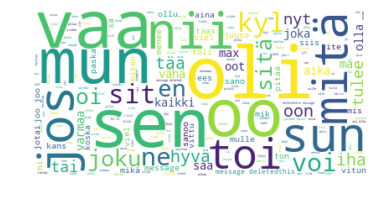

samuli 23


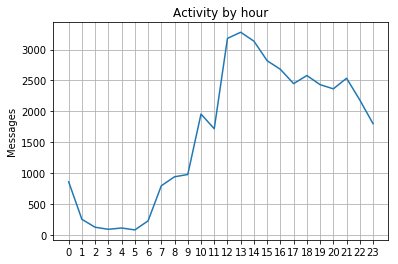

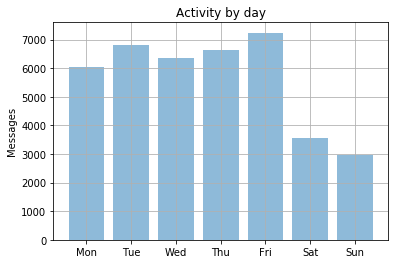

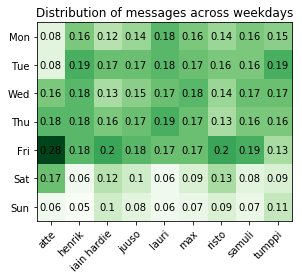

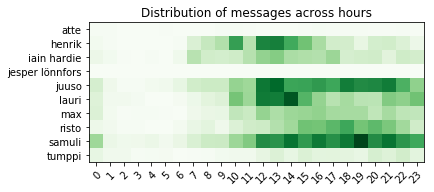

In [6]:
# Analytics

# Wordcloud
plot_wordcloud(data_matrix)

top_blazer, hits = get_top_420(data_matrix)
print(top_blazer, hits)

#get_longest_rant(data_matrix)

# Hourly activity
hour, count = get_activity_by_hour(data_matrix)
plot_activity_by_hour(hour,count)

# Daily activity
day, count = get_activity_by_day(data_matrix)
plot_activity_by_day(day, count)

# User activity by weekday
plot_users_activity_by_day(data_matrix)

# User activity by hour
plot_users_activity_by_hour(data_matrix)

In [107]:
from sklearn.feature_extraction.text import CountVectorizer

# Create CountVectorizer object
vectorizer = CountVectorizer()

def get_tokens(data_matrix):
    messages = data_matrix.T[3]
    tokens = []
    for msg in messages:
        words_in_msg = msg.split(' ')
        for word in words_in_msg:
            tokens.append(word)
    tokens = list(set(tokens))
    
    print(len(tokens), 'tokens')

    return tokens

# Create feature matrix
# [hour, day, message vector]

def create_feature_matrix(data_matrix):
    date = data_matrix.T[0]
    
    helper = np.vectorize(lambda x: x.hour)
    hour_vector = np.asarray(helper(date))
    
    helper = np.vectorize(lambda x: x.weekday())
    day_vector = np.asarray(helper(date))

    # create CountVectorizer object
    vectorizer = CountVectorizer()

    corpus = data_matrix.T[3]

    # learn the vocabulary and store CountVectorizer sparse matrix in X
    X = vectorizer.fit_transform(corpus)

    # columns of X correspond to the result of this method
    tokens = get_tokens(data_matrix)
    vectorizer.get_feature_names() == (tokens)

    # retrieving the matrix in the numpy form
    X.toarray()

    # transforming a new document according to learn vocabulary
    # vectorizer.transform(['hae lava']).toarray()
    msg_vector = []
    messages = data_matrix.T[3]
    
    for msg in messages:
        msg = msg.split(' ')
        t = vectorizer.transform(msg).toarray()
        #print(t.shape)
        msg_vector.append(t)
        
    msg_vector = np.asarray(msg_vector)
    
    feature_matrix = np.column_stack((hour_vector, day_vector, msg_vector))
    print('Feature matrix shape:')
    print(feature_matrix.shape)
    
    return feature_matrix


    

In [108]:
# Hour, day, message
X = create_feature_matrix(data_matrix)
Y = data_matrix.T[2]

print('Label vector shape')
print(Y.shape)


32814 tokens
Feature matrix shape:
(39636, 3)
Label vector shape
(39636,)


In [109]:
tokens = get_tokens(data_matrix)

def message_to_vector(message):
    init = np.zeros(len(tokens))
    for w in message:
        print(w)
        indices = np.where(tokens == w)
        print(indices)
    values = np.ones(indices[0].shape)
    print(values.shape)
    a = np.put(init, indices, values)
    print(np.where(a==1))
    
message_to_vector(['isompi', 'maksoks'])
    
    

32814 tokens
isompi
(array([], dtype=int64),)
maksoks
(array([], dtype=int64),)
(0,)
(array([], dtype=int64),)
